In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data

In [37]:
df = pd.read_csv('/content/drive/MyDrive/ADL final project/data/final_input.csv', index_col = [0])
df.tail()

,Open,Close,High,Low,Volume_x,Volume_y,MA,Returns,BBand_upper,BBand_middle,BBand_lower,Average Directional Index,Directional Index,MACD,MACD_signal,MACD hist,stochastic k,stochastic d,movement
93164,122.220,122.185,122.2550,122.1650,3.3619,3.440,122.062857,-0.000053,122.279334,122.036715,121.794096,18.047640,19.461349,-0.019483,-0.026656,0.007173,56.997702,37.459158,0
93165,122.195,122.210,122.2205,122.1350,1.7607,1.670,122.056429,-0.000053,122.342990,122.082559,121.822129,17.821065,14.875593,-0.007855,-0.022896,0.015041,83.065749,58.266148,0
93166,122.220,122.235,122.2455,122.1395,3.7251,3.880,122.063214,0.000056,122.371346,122.129983,121.888620,17.813164,17.710453,0.003339,-0.017649,0.020988,83.830275,74.631242,1
93167,122.245,122.230,122.2555,122.1495,4.1460,4.380,122.071786,0.000070,122.207497,122.171386,122.135275,17.888957,18.874260,0.011672,-0.011785,0.023457,87.270642,84.722222,1
93168,122.235,122.455,122.4750,122.2200,8.1707,8.655,122.104643,0.000269,122.424819,122.229616,122.034414,19.411206,39.200444,0.036016,-0.002225,0.038241,90.699766,87.266895,1


In [3]:
train_size = int(len(df) * .7)
df_train =  df.iloc[:train_size]
df_val = df.iloc[train_size:]

print(len(df_train), len(df_val))

65218 27951


In [5]:
#Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

feature_columns = ['Open', 'High', 'Low', 'Volume_x', 'Volume_y', 'MA', 'Returns',
       'BBand_upper', 'BBand_middle', 'BBand_lower', 'Directional Index',
       'Average Directional Index', 'MACD', 'MACD_signal', 'MACD hist',
        'stochastic k', 'stochastic d']


for feature in feature_columns:
  df_train[feature] = scaler.fit_transform(df_train[[feature]].values)
  df_val[feature] = scaler.transform(df_val[[feature]])



In [6]:
from tensorflow.keras.utils import to_categorical

Y_train = df_train['movement']
Y_val = df_val['movement']

print(len(Y_train[Y_train == 1]), len(Y_train[Y_train == 0]))
print(len(Y_val[Y_val == 1]), len(Y_val[Y_val == 0]))

Y_train = to_categorical(Y_train, 2)
Y_val = to_categorical(Y_val, 2)

34209 31009
14165 13786


In [7]:
def convert_raw_samples_to_model_samples(scd_log_rtns, movements, window_size):
    X, y = [], []
    len_log_rtns = len(scd_log_rtns)
    for i in range(window_size, len_log_rtns):
        X.append(scd_log_rtns[i-window_size:i])
        y.append(movements[i])
    X, y = np.asarray(X), np.asarray(y)
    #X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y


In [8]:
df_train = df_train.dropna()
df_train.index = np.arange(0,len(df_train))
df_val.index = np.arange(0,len(df_val))

df_train = df_train[feature_columns]
df_val  = df_val[feature_columns]

In [9]:
window_size = 300
X_train, y_train = convert_raw_samples_to_model_samples(df_train, Y_train, window_size)
X_val, y_val = convert_raw_samples_to_model_samples(df_val, Y_val, window_size)
#X_test, y_test = convert_raw_samples_to_model_samples(test_values, test_y_values, window_size)

## Embedding

In [10]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

In [11]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [12]:
# -*- coding: utf-8 -*-
"""Confusion matrix.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1dbeSXmnx5b6mUMXXYMlYVw-V20-fDdPc
"""

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Model

In [13]:
def reshape_lv(array, lv):
  '''
  array shape must in the form of (batch_size, window_size, feature_num)
  '''
  arr_shape = array.shape
  arr = np.reshape(array, ((arr_shape[1], arr_shape[0], arr_shape[2])))
  new_arr = [arr[i *lv] for i in range(len(arr)//lv)]

  new_arr = np.asarray(new_arr)
  new_arr = np.reshape(new_arr, (new_arr.shape[1], new_arr.shape[0], new_arr.shape[2]))

  return new_arr


In [14]:
X_train_lv5 = reshape_lv(X_train, 5)
X_train_lv20 = reshape_lv(X_train, 20)
X_train_lv100 = reshape_lv(X_train, 100)

X_val_lv5 = reshape_lv(X_val, 5)
X_val_lv20 = reshape_lv(X_val, 20)
X_val_lv100 = reshape_lv(X_val, 100)

print(X_train_lv5.shape, X_train_lv20.shape, X_train_lv100.shape)
print(X_val_lv5.shape, X_val_lv20.shape, X_val_lv100.shape)

(64885, 60, 17) (64885, 15, 17) (64885, 3, 17)
(27651, 60, 17) (27651, 15, 17) (27651, 3, 17)


In [15]:
X_train_vlstm = [X_train, X_train_lv5, X_train_lv20, X_train_lv100]
X_val_vlstm = [X_val, X_val_lv5, X_val_lv20, X_val_lv100]

In [16]:
def create_VLSTM(X, classification, embedding):
  '''
  input: X: list of np.array in shape of (batch_size, window_size, feature_num) 
  X = [X_lv1, X_lv5, X_lv20, X_lv100]
  '''
  RNN_CELL_SIZE = 64

  input_seq_lv1 = Input(shape = (X[0].shape[1], X[0].shape[2]))
  input_seq_lv5 = Input(shape = (X[1].shape[1], X[1].shape[2]))
  input_seq_lv20 = Input(shape = (X[2].shape[1], X[2].shape[2]))
  input_seq_lv100 = Input(shape = (X[3].shape[1], X[3].shape[2]))

  if embedding:
    time_embedding_lv1 = Time2Vector(X[0].shape[1])
    time_embedding_lv5 = Time2Vector(X[1].shape[1])
    time_embedding_lv20 = Time2Vector(X[2].shape[1])
    time_embedding_lv100 = Time2Vector(X[3].shape[1])

    x_lv1 = time_embedding_lv1(input_seq_lv1)
    x_lv5 = time_embedding_lv5(input_seq_lv5)
    x_lv20 = time_embedding_lv20(input_seq_lv20)
    x_lv100 = time_embedding_lv100(input_seq_lv100)

    x_lv1 = Concatenate(axis=-1)([input_seq_lv1, x_lv1])
    x_lv5 = Concatenate(axis=-1)([input_seq_lv5, x_lv5])
    x_lv20 = Concatenate(axis=-1)([input_seq_lv20, x_lv20])
    x_lv100 = Concatenate(axis=-1)([input_seq_lv100, x_lv100])

    x_lv1 = LSTM(RNN_CELL_SIZE, return_sequences= True)(x_lv1)
    x_lv5 = LSTM(RNN_CELL_SIZE, return_sequences= True)(x_lv5)
    x_lv20 = LSTM(RNN_CELL_SIZE, return_sequences= True)(x_lv20)
    x_lv100 = LSTM(RNN_CELL_SIZE, return_sequences= True)(x_lv100)
  else:
    x_lv1 = LSTM(RNN_CELL_SIZE, return_sequences= True)(input_seq_lv1)
    x_lv5 = LSTM(RNN_CELL_SIZE, return_sequences= True)(input_seq_lv5)
    x_lv20 = LSTM(RNN_CELL_SIZE, return_sequences= True)(input_seq_lv20)
    x_lv100 = LSTM(RNN_CELL_SIZE, return_sequences= True)(input_seq_lv100)

    
  x_lv1 = LSTM(RNN_CELL_SIZE, return_sequences= True)(x_lv1)
  x_lv5 = LSTM(RNN_CELL_SIZE, return_sequences= True)(x_lv5)
  x_lv20 = LSTM(RNN_CELL_SIZE, return_sequences= True)(x_lv20)
  x_lv100 = LSTM(RNN_CELL_SIZE, return_sequences= True)(x_lv100)

  flat_x_lv1 = Flatten()(x_lv1)
  flat_x_lv5 = Flatten()(x_lv5)
  flat_x_lv20 = Flatten()(x_lv20)
  flat_x_lv100 = Flatten()(x_lv100)

  x = concatenate([flat_x_lv1,flat_x_lv5,flat_x_lv20,flat_x_lv100], axis=1)
  
  if classification:
    x = Dropout(0.1)(x)
    x = Dense(128, activation = 'relu')(x)
    out = Dense(2, activation="softmax", name="output")(x)
    model = Model(inputs = [input_seq_lv1, input_seq_lv5,input_seq_lv20,input_seq_lv100], outputs = out)
    model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(1e-5), metrics = ['acc',f1_m,precision_m, recall_m])
  else:
    x = Dropout(0.1)(x)
    out = Dense(1)(x)
    model = Model(inputs = [input_seq_lv1, input_seq_lv5,input_seq_lv20,input_seq_lv100], outputs = out)
    model.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(1e-5), metrics = ['mae', 'mape'])
  
  return model

In [17]:
#With time embedding
vlstm_time_model = create_VLSTM(X_train_vlstm, True, True)
vlstm_notime_model = create_VLSTM(X_train_vlstm, True, False)

In [18]:
history_time = vlstm_time_model.fit(X_train_vlstm, y_train,epochs=5,  validation_data=(X_val_vlstm, y_val))
history_notime = vlstm_notime_model.fit(X_train_vlstm, y_train,epochs=5,  validation_data=(X_val_vlstm, y_val))

Epoch 1/5
2028/2028 [==============================] - 107s 47ms/step - loss: 0.5900 - acc: 0.6732 - f1_m: 0.6732 - precision_m: 0.6732 - recall_m: 0.6732 - val_loss: 1.0892 - val_acc: 0.4999 - val_f1_m: 0.5005 - val_precision_m: 0.5005 - val_recall_m: 0.5005
Epoch 2/5
2028/2028 [==============================] - 92s 45ms/step - loss: 0.3380 - acc: 0.8481 - f1_m: 0.8481 - precision_m: 0.8481 - recall_m: 0.8481 - val_loss: 1.2267 - val_acc: 0.5050 - val_f1_m: 0.5056 - val_precision_m: 0.5056 - val_recall_m: 0.5056
Epoch 3/5
2028/2028 [==============================] - 92s 45ms/step - loss: 0.3150 - acc: 0.8581 - f1_m: 0.8581 - precision_m: 0.8581 - recall_m: 0.8581 - val_loss: 1.2331 - val_acc: 0.5020 - val_f1_m: 0.5026 - val_precision_m: 0.5026 - val_recall_m: 0.5026
Epoch 4/5
2028/2028 [==============================] - 93s 46ms/step - loss: 0.3103 - acc: 0.8602 - f1_m: 0.8602 - precision_m: 0.8602 - recall_m: 0.8602 - val_loss: 1.2521 - val_acc: 0.5009 - val_f1_m: 0.5014 - val_precis

In [19]:
y_pred_time = vlstm_time_model.predict(X_val_vlstm)
y_pred_notime = vlstm_time_model.predict(X_val_vlstm)

y_pred_time = [y_pred_time[i].argmax() for i in range(len(y_pred_time))]
y_pred_notime = [y_pred_notime[i].argmax() for i in range(len(y_pred_notime))]



In [22]:
from sklearn.metrics import classification_report
y_true =  [y_val[i].argmax() for i in range(len(y_val))]
print('with Embedding')
print(classification_report(y_true, y_pred_time))
print('--------------------------')
print('without Embedding')
print(classification_report(y_true, y_pred_notime))

with Embedding
              precision    recall  f1-score   support

           0       0.49      0.36      0.42     13668
           1       0.50      0.64      0.56     13983

    accuracy                           0.50     27651
   macro avg       0.50      0.50      0.49     27651
weighted avg       0.50      0.50      0.49     27651

--------------------------
without Embedding
              precision    recall  f1-score   support

           0       0.49      0.36      0.42     13668
           1       0.50      0.64      0.56     13983

    accuracy                           0.50     27651
   macro avg       0.50      0.50      0.49     27651
weighted avg       0.50      0.50      0.49     27651



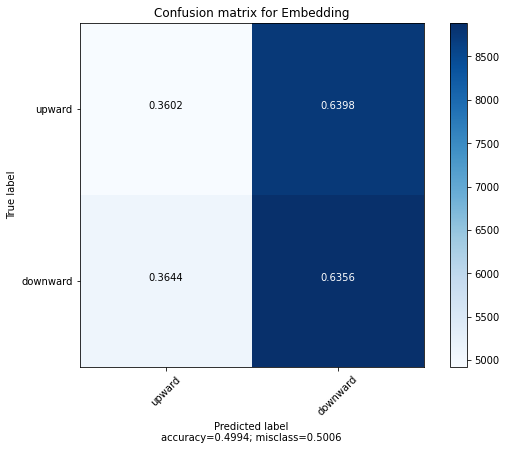

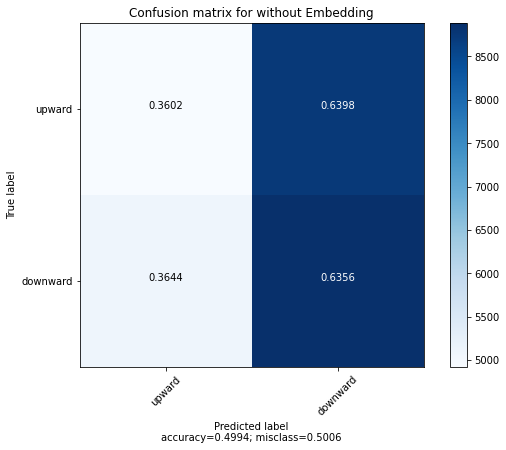

In [25]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred_time)
plot_confusion_matrix(cm,
                      ['upward','downward'],
                      title='Confusion matrix for Embedding',
                      cmap=None,
                      normalize=True)

cm = confusion_matrix(y_true, y_pred_notime)
plot_confusion_matrix(cm,
                      ['upward','downward'],
                      title='Confusion matrix for without Embedding',
                      cmap=None,
                      normalize=True)

In [38]:
final_result = pd.DataFrame()
final_result['y_true'] = y_true
final_result['vlstm_with_time'] = y_pred_time
final_result['vlstm_without_time'] = y_pred_notime
final_result.to_csv('/content/drive/MyDrive/ADL final project/data/vlstm_output.csv')